In [1]:
# Dataset
link = "https://www.dropbox.com/scl/fi/30fgnvr78ghmf9l37t8yl/AutSER.zip?rlkey=l7n409pk3u5i4xb5raf28tfog&dl=0"

In [2]:
!wget -O autser.zip $link

'wget' is not recognized as an internal or external command,
operable program or batch file.
'dl' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
!unzip autser.zip

'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [4]:
!git clone https://github.com/alireza0r/AutSER.git

'git' is not recognized as an internal or external command,
operable program or batch file.


In [5]:
!git -C "AutSER" pull

'git' is not recognized as an internal or external command,
operable program or batch file.


In [6]:
from AutSER import feature_extractor

ModuleNotFoundError: No module named 'AutSER'

In [ ]:
result = feature_extractor.featureExtractor()

In [3]:
import os
import pandas as pd
import numpy as np
import librosa

def featureExtractor(path='./AutSED_New_Name_selectedData', SR=44100):
    files = os.listdir(path)
    np.random.shuffle(files)
    audio_length = int(5*SR)

    label_symbol = {'H':0, 'A':1, 'S':2, 'N':3}
    feature_stack = []
    label_stack = []
    for f in files:
        label_stack.append(label_symbol[f[3]])
        audio, SR = librosa.load(os.path.join(path, f), sr=44100)

        if len(audio) < audio_length:
            audio = np.concatenate((audio, np.zeros(audio_length - len(audio))))
        elif len(audio) > audio_length:
            audio = audio[:audio_length]

        feature = librosa.feature.mfcc(y=audio, sr=SR, n_mfcc=20)
        feature_stack.append(feature)
        #print(feature.shape)

    feature_stack = np.stack(feature_stack, axis=0)
    #print(feature_stack.shape)
    return feature_stack, np.array(label_stack)

result = featureExtractor(r"P:\University\Master\MyPapers\AutESD\Code\AutSED_New_Name_selectedData")

In [4]:
import numpy as np
feature, label = result
feature = np.expand_dims(feature, -3)

print(feature.shape)
print(label.shape)

(1428, 1, 20, 431)
(1428,)


In [7]:
np.max(label)

3

In [8]:
# one hot labeling

def onehotEncoder(label, nclass=4):
    new_label = np.zeros(shape=(len(label), nclass))
    for i, l in enumerate(label):
        new_label[i,l] = 1
    return new_label
onehot_label = onehotEncoder(label)
print(onehot_label.shape)

(1428, 4)


In [9]:
onehot_label

array([[0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       ...,
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]])

In [10]:
import torch
import torch.nn as nn

class DNN(nn.Module):
  def __init__(self):
    super().__init__()

    self.cnn_1 = nn.Sequential(nn.Conv2d(1, 16, (3, 5), (1, 2)), nn.ReLU(), nn.MaxPool2d((3, 5), (3, 5)))
    self.cnn_2 = nn.Sequential(nn.Conv2d(16, 32, 3, 1), nn.ReLU(), nn.MaxPool2d((1, 2), (1, 2)))
    self.cnn_3 = nn.Sequential(nn.Conv2d(32, 64, 3, 1), nn.ReLU(), nn.MaxPool2d((1, 2), (1, 2)))

    self.flat = nn.Flatten(start_dim=1, end_dim=-1)

    self.l1 = nn.Sequential(nn.Linear(1152, 64), nn.ReLU())
    self.l2 = nn.Sequential(nn.Linear(64, 16), nn.ReLU())
    self.l3 = nn.Sequential(nn.Linear(16, 4), nn.Softmax())

  def forward(self, x):
    x = self.cnn_1(x)
    # print(x.size())

    x = self.cnn_2(x)
    # print(x.size())

    x = self.cnn_3(x)
    # print(x.size())

    x = self.flat(x)
    # print(x.size())

    x = self.l1(x)
    # print(x.size())

    x = self.l2(x)
    # print(x.size())

    x = self.l3(x)
    # print(x.size())
    return x

In [12]:
from sklearn.model_selection import StratifiedKFold
import numpy as np

KF = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_labels = np.argmax(onehot_label, axis=1)

for i, (train_index, test_index) in enumerate(KF.split(feature, y_labels)):
    x_train, x_test = feature[train_index], feature[test_index]
    y_train, y_test = onehot_label[train_index], onehot_label[test_index]  # هنوز one-hot باقی می‌ماند

    print(i, x_train.shape, y_train.shape)

0 (1142, 1, 20, 431) (1142, 4)
1 (1142, 1, 20, 431) (1142, 4)
2 (1142, 1, 20, 431) (1142, 4)
3 (1143, 1, 20, 431) (1143, 4)
4 (1143, 1, 20, 431) (1143, 4)


In [21]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def confusion_matrix_evaluation(model, x, y, class_names = ['H', 'A', 'S', 'N'], title='', save_path="confusion_matrix.png"):
  # Evaluate the model
  model.eval()

  # Storing all the predictions and actual labels
  all_preds = []
  all_labels = []

  with torch.no_grad():
      for data, label in zip(x, y):
          outputs = model(torch.tensor(data, dtype=torch.float).to(device).unsqueeze(0))
          predicted = torch.argmax(outputs, -1)
          all_preds.extend(predicted.numpy())
          all_labels.extend(np.argmax(label.reshape(1,-1), -1))

  # Calculate the confusion matrix
  cm = confusion_matrix(all_labels, all_preds, normalize='true')

  # Plot the confusion matrix
  plt.figure(figsize=(10, 7))
  sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=class_names, yticklabels=class_names, cmap='Blues', cbar=False)
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.title(title)

      # 🔹 ذخیره در صورت تعیین مسیر
  if save_path is not None:
      plt.savefig(save_path, dpi=300, bbox_inches='tight')
      print(f"✅ Confusion matrix saved to: {save_path}")

  plt.close()  # جلوگیری از باز ماندن شکل در حافظه

  # plt.show()

In [24]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
import numpy as np
from sklearn.model_selection import train_test_split

KF = StratifiedKFold(n_splits=5, shuffle=True)
confusion_matrix_train_list = []
confusion_matrix_test_list = []
y_labels = np.argmax(onehot_label, axis=1)
for i, (train_index, test_index) in enumerate(KF.split(feature, y_labels)):
    X, Y = feature[train_index], onehot_label[train_index]
    x_test, y_test = feature[test_index], onehot_label[test_index]

    x_train, x_valid, y_train, y_valid = train_test_split(X, Y, train_size=0.7, shuffle=True)

    model = DNN()

    # Parameters
    num_epochs = 200
    batch_size = 64
    learning_rate = 0.003

    # Device
    device = 'cude' if torch.cuda.is_available() else 'cpu'

    # Loss and optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)


    train_loss_list = []
    valid_loss_list = []
    train_acc_list = []
    valid_acc_list = []
    loss_list = []
    # Train the model
    for epoch in range(num_epochs):
        model.train()
        batches = np.arange(x_train.shape[0])
        np.random.shuffle(batches)

        batches = np.array_split(batches, x_train.shape[0]//batch_size)
        for b in batches:
            # Forward pass
            outputs = model(torch.tensor(x_train[b], dtype=torch.float).to(device))
            loss = criterion(outputs, torch.tensor(y_train[b], dtype=torch.float).to(device))

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_list.append(loss.item())
        # train_loss_list.append(loss_list/len(loss_list))


        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for data, label in zip(x_valid, y_valid):
                outputs = model(torch.tensor(data, dtype=torch.float).to(device).unsqueeze(0))
                predicted = torch.argmax(outputs, -1)
                total += 1
                # print(predicted.item(), np.argmax(label))
                correct += (predicted.item() == np.argmax(label))
                loss_list.append(criterion(outputs.squeeze(), torch.tensor(label, dtype=torch.float).to(device)).item())

            print(f'Accuracy: {100 * correct / total} %')
            valid_acc_list.append(100 * correct / total)
            # valid_loss_list.append(loss_list/len(loss_list))
        print(f'Epoch [{epoch+1}/{num_epochs}], last Loss: {loss.item():.4f}')

        print("Training complete!")
        scheduler.step()

    # Test
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for data, label in zip(x_test, y_test):
            outputs = model(torch.tensor(data, dtype=torch.float).to(device).unsqueeze(0))
            predicted = torch.argmax(outputs, -1)
            total += 1
            correct += (predicted.item() == np.argmax(label))

        print(f'Accuracy: {100 * correct / total} %')

    confusion_matrix_evaluation(model, x_test, y_test, save_path=f"confusion_matrix_test_fold_{i}.png")

    print("Evaluation complete!")

e:\Hoosha\Codes\hoosha_env\Lib\site-packages\torch\nn\modules\module.py:1751: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Accuracy: 25.364431486880466 %
Epoch [1/200], last Loss: 1.4352
Training complete!
Accuracy: 26.239067055393587 %
Epoch [2/200], last Loss: 1.3412
Training complete!
Accuracy: 36.44314868804665 %
Epoch [3/200], last Loss: 1.3710
Training complete!
Accuracy: 40.816326530612244 %
Epoch [4/200], last Loss: 1.3211
Training complete!
Accuracy: 35.56851311953353 %
Epoch [5/200], last Loss: 1.3463
Training complete!
Accuracy: 40.2332361516035 %
Epoch [6/200], last Loss: 1.3154
Training complete!
Accuracy: 41.39941690962099 %
Epoch [7/200], last Loss: 1.2954
Training complete!
Accuracy: 38.775510204081634 %
Epoch [8/200], last Loss: 1.2640
Training complete!
Accuracy: 45.481049562682216 %
Epoch [9/200], last Loss: 1.2510
Training complete!
Accuracy: 44.89795918367347 %
Epoch [10/200], last Loss: 1.2169
Training complete!
Accuracy: 50.72886297376093 %
Epoch [11/200], last Loss: 1.2293
Training complete!
Accuracy: 43.731778425655975 %
Epoch [12/200], last Loss: 1.1805
Training complete!
Accuracy

e:\Hoosha\Codes\hoosha_env\Lib\site-packages\torch\nn\modules\module.py:1751: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Accuracy: 35.56851311953353 %
Epoch [1/200], last Loss: 1.3686
Training complete!
Accuracy: 31.486880466472304 %
Epoch [2/200], last Loss: 1.3773
Training complete!
Accuracy: 38.775510204081634 %
Epoch [3/200], last Loss: 1.3938
Training complete!
Accuracy: 39.650145772594755 %
Epoch [4/200], last Loss: 1.3758
Training complete!
Accuracy: 41.690962099125365 %
Epoch [5/200], last Loss: 1.3784
Training complete!
Accuracy: 41.98250728862974 %
Epoch [6/200], last Loss: 1.3572
Training complete!
Accuracy: 41.98250728862974 %
Epoch [7/200], last Loss: 1.3351
Training complete!
Accuracy: 42.27405247813411 %
Epoch [8/200], last Loss: 1.3386
Training complete!
Accuracy: 42.565597667638485 %
Epoch [9/200], last Loss: 1.2799
Training complete!
Accuracy: 42.565597667638485 %
Epoch [10/200], last Loss: 1.3022
Training complete!
Accuracy: 40.2332361516035 %
Epoch [11/200], last Loss: 1.2136
Training complete!
Accuracy: 42.857142857142854 %
Epoch [12/200], last Loss: 1.3035
Training complete!
Accurac

e:\Hoosha\Codes\hoosha_env\Lib\site-packages\torch\nn\modules\module.py:1751: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Accuracy: 35.8600583090379 %
Epoch [1/200], last Loss: 1.3945
Training complete!
Accuracy: 41.10787172011662 %
Epoch [2/200], last Loss: 1.3829
Training complete!
Accuracy: 44.31486880466473 %
Epoch [3/200], last Loss: 1.3753
Training complete!
Accuracy: 44.02332361516035 %
Epoch [4/200], last Loss: 1.3381
Training complete!
Accuracy: 42.857142857142854 %
Epoch [5/200], last Loss: 1.3457
Training complete!
Accuracy: 44.89795918367347 %
Epoch [6/200], last Loss: 1.3194
Training complete!
Accuracy: 45.18950437317784 %
Epoch [7/200], last Loss: 1.2892
Training complete!
Accuracy: 43.731778425655975 %
Epoch [8/200], last Loss: 1.2959
Training complete!
Accuracy: 46.06413994169096 %
Epoch [9/200], last Loss: 1.2652
Training complete!
Accuracy: 43.440233236151606 %
Epoch [10/200], last Loss: 1.2733
Training complete!
Accuracy: 46.35568513119534 %
Epoch [11/200], last Loss: 1.2282
Training complete!
Accuracy: 46.06413994169096 %
Epoch [12/200], last Loss: 1.2160
Training complete!
Accuracy: 4

e:\Hoosha\Codes\hoosha_env\Lib\site-packages\torch\nn\modules\module.py:1751: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Accuracy: 27.988338192419825 %
Epoch [1/200], last Loss: 1.3740
Training complete!
Accuracy: 34.40233236151604 %
Epoch [2/200], last Loss: 1.3807
Training complete!
Accuracy: 36.44314868804665 %
Epoch [3/200], last Loss: 1.3955
Training complete!
Accuracy: 39.067055393586 %
Epoch [4/200], last Loss: 1.3841
Training complete!
Accuracy: 39.35860058309038 %
Epoch [5/200], last Loss: 1.3674
Training complete!
Accuracy: 42.27405247813411 %
Epoch [6/200], last Loss: 1.3592
Training complete!
Accuracy: 41.690962099125365 %
Epoch [7/200], last Loss: 1.3582
Training complete!
Accuracy: 41.10787172011662 %
Epoch [8/200], last Loss: 1.3337
Training complete!
Accuracy: 43.731778425655975 %
Epoch [9/200], last Loss: 1.3260
Training complete!
Accuracy: 40.816326530612244 %
Epoch [10/200], last Loss: 1.3343
Training complete!
Accuracy: 43.731778425655975 %
Epoch [11/200], last Loss: 1.3359
Training complete!
Accuracy: 47.521865889212826 %
Epoch [12/200], last Loss: 1.3167
Training complete!
Accuracy:

e:\Hoosha\Codes\hoosha_env\Lib\site-packages\torch\nn\modules\module.py:1751: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Accuracy: 24.78134110787172 %
Epoch [1/200], last Loss: 1.3808
Training complete!
Accuracy: 37.02623906705539 %
Epoch [2/200], last Loss: 1.3837
Training complete!
Accuracy: 38.48396501457726 %
Epoch [3/200], last Loss: 1.3693
Training complete!
Accuracy: 33.52769679300292 %
Epoch [4/200], last Loss: 1.3689
Training complete!
Accuracy: 43.440233236151606 %
Epoch [5/200], last Loss: 1.3636
Training complete!
Accuracy: 42.565597667638485 %
Epoch [6/200], last Loss: 1.3611
Training complete!
Accuracy: 53.06122448979592 %
Epoch [7/200], last Loss: 1.3628
Training complete!
Accuracy: 47.8134110787172 %
Epoch [8/200], last Loss: 1.3426
Training complete!
Accuracy: 50.72886297376093 %
Epoch [9/200], last Loss: 1.3401
Training complete!
Accuracy: 54.518950437317784 %
Epoch [10/200], last Loss: 1.3223
Training complete!
Accuracy: 55.97667638483965 %
Epoch [11/200], last Loss: 1.3507
Training complete!
Accuracy: 53.352769679300295 %
Epoch [12/200], last Loss: 1.3439
Training complete!
Accuracy: 

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(feature, onehot_label, train_size=0.7, shuffle=True)
x_valid, x_test, y_valid, y_test = train_test_split(x_valid, y_valid, train_size=0.66, shuffle=True)

print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)
print(x_test.shape)
print(y_test.shape)

(999, 1, 20, 431)
(999, 4)
(283, 1, 20, 431)
(283, 4)
(146, 1, 20, 431)
(146, 4)


In [82]:
model = DNN()

# Parameters
num_epochs = 200
batch_size = 64
learning_rate = 0.001

# Device
device = 'cude' if torch.cuda.is_available() else 'cpu'

# Loss and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

train_loss_list = []
valid_loss_list = []
train_acc_list = []
valid_acc_list = []
loss_list = []
# Train the model
for epoch in range(num_epochs):
  # model.train()
  batches = np.arange(x_train.shape[0])
  np.random.shuffle(batches)

  batches = np.array_split(batches, x_train.shape[0]//batch_size)
  for b in batches:
    # Forward pass
    outputs = model(torch.tensor(x_train[b], dtype=torch.float).to(device))
    loss = criterion(outputs, torch.tensor(y_train[b], dtype=torch.float).to(device))

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_list.append(loss.item())
  train_loss_list.append(loss_list/len(loss_list))


  # model.eval()
  with torch.no_grad():
      correct = 0
      total = 0
      for data, label in zip(x_valid, y_valid):
          outputs = model(torch.tensor(data, dtype=torch.float).to(device).unsqueeze(0))
          predicted = torch.argmax(outputs, -1)
          total += 1
          # print(predicted.item(), np.argmax(label))
          correct += (predicted.item() == np.argmax(label))
          loss_list.append(criterion(outputs, torch.tensor(label, dtype=torch.float).to(device)).item())

      print(f'Accuracy: {100 * correct / total} %')
      valid_acc_list.append(100 * correct / total)
      valid_loss_list.append(loss_list/len(loss_list))
  print(f'Epoch [{epoch+1}/{num_epochs}], last Loss: {loss.item():.4f}')

print("Training complete!")

Accuracy: 22.261484098939928 %
Epoch [1/200], last Loss: 1.3977
Accuracy: 27.208480565371026 %
Epoch [2/200], last Loss: 1.3720
Accuracy: 31.09540636042403 %
Epoch [3/200], last Loss: 1.3949
Accuracy: 31.802120141342755 %
Epoch [4/200], last Loss: 1.3742
Accuracy: 33.21554770318021 %
Epoch [5/200], last Loss: 1.3800
Accuracy: 33.56890459363957 %
Epoch [6/200], last Loss: 1.3854
Accuracy: 33.56890459363957 %
Epoch [7/200], last Loss: 1.3823
Accuracy: 34.628975265017665 %
Epoch [8/200], last Loss: 1.3827
Accuracy: 34.275618374558306 %
Epoch [9/200], last Loss: 1.3767
Accuracy: 33.92226148409894 %
Epoch [10/200], last Loss: 1.3707
Accuracy: 33.92226148409894 %
Epoch [11/200], last Loss: 1.3647
Accuracy: 34.275618374558306 %
Epoch [12/200], last Loss: 1.3291
Accuracy: 34.275618374558306 %
Epoch [13/200], last Loss: 1.3672
Accuracy: 36.042402826855124 %
Epoch [14/200], last Loss: 1.3628
Accuracy: 37.102473498233216 %
Epoch [15/200], last Loss: 1.3725
Accuracy: 36.39575971731449 %
Epoch [16/

Text(0, 0.5, 'Accuracy %')

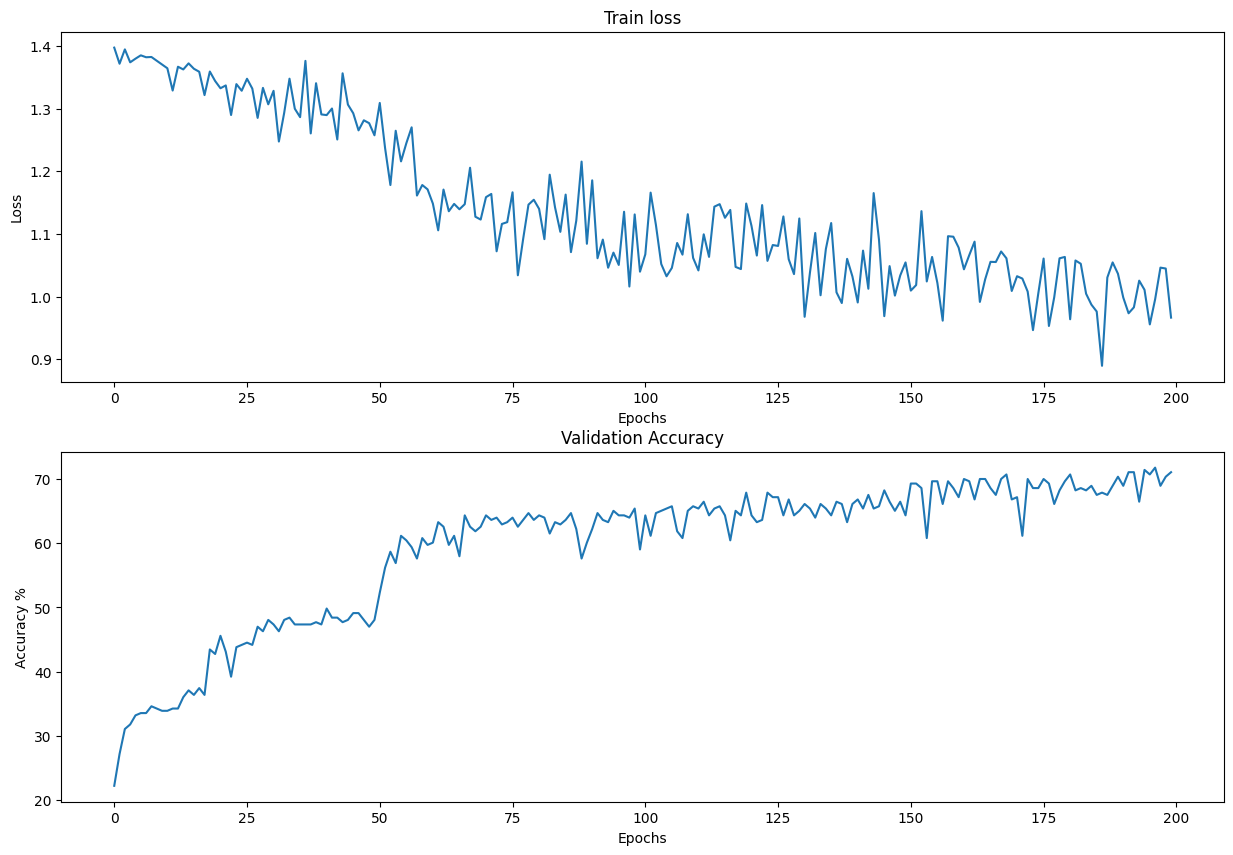

In [86]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2,1, figsize=(15,10))
ax[0].plot(loss_list)
ax[0].set_title('Train loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')

ax[1].plot(val_acc_list)
ax[1].set_title('Validation Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy %')

In [87]:
import torch

# Model initialization (ensure it's the same configuration as training)
# model = DNN()

# Load the trained model weights
# model.load_state_dict(torch.load('model.ckpt'))

# Evaluate the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for data, label in zip(x_test, y_test):
        outputs = model(torch.tensor(data, dtype=torch.float).to(device).unsqueeze(0))
        predicted = torch.argmax(outputs, -1)
        total += 1
        correct += (predicted.item() == np.argmax(label))

    print(f'Accuracy: {100 * correct / total} %')

print("Evaluation complete!")


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Accuracy: 76.02739726027397 %
Evaluation complete!


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def confusion_matrix_evaluation(model, x, y, class_names = ['H', 'A', 'S', 'N'], title='', save_path="confusion_matrix.png"):
  # Evaluate the model
  model.eval()

  # Storing all the predictions and actual labels
  all_preds = []
  all_labels = []

  with torch.no_grad():
      for data, label in zip(x, y):
          outputs = model(torch.tensor(data, dtype=torch.float).to(device).unsqueeze(0))
          predicted = torch.argmax(outputs, -1)
          all_preds.extend(predicted.numpy())
          all_labels.extend(np.argmax(label.reshape(1,-1), -1))

  # Calculate the confusion matrix
  cm = confusion_matrix(all_labels, all_preds, normalize='true')

  # Plot the confusion matrix
  plt.figure(figsize=(10, 7))
  sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=class_names, yticklabels=class_names, cmap='Blues', cbar=False)
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.title(title)

      # 🔹 ذخیره در صورت تعیین مسیر
  if save_path is not None:
      plt.savefig(save_path, dpi=300, bbox_inches='tight')
      print(f"✅ Confusion matrix saved to: {save_path}")

  plt.close()  # جلوگیری از باز ماندن شکل در حافظه

  # plt.show()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


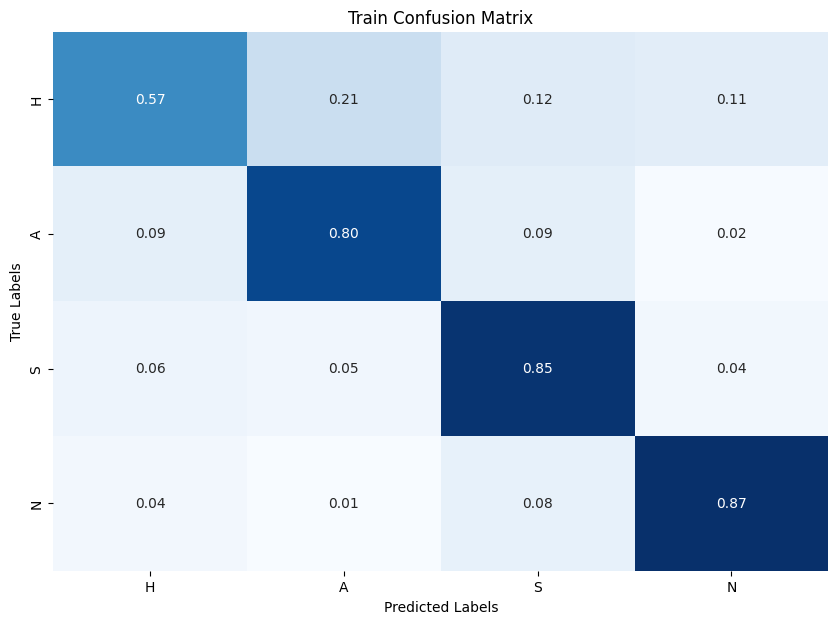

In [102]:
confusion_matrix_evaluation(model, x_train, y_train, title='Train Confusion Matrix')

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


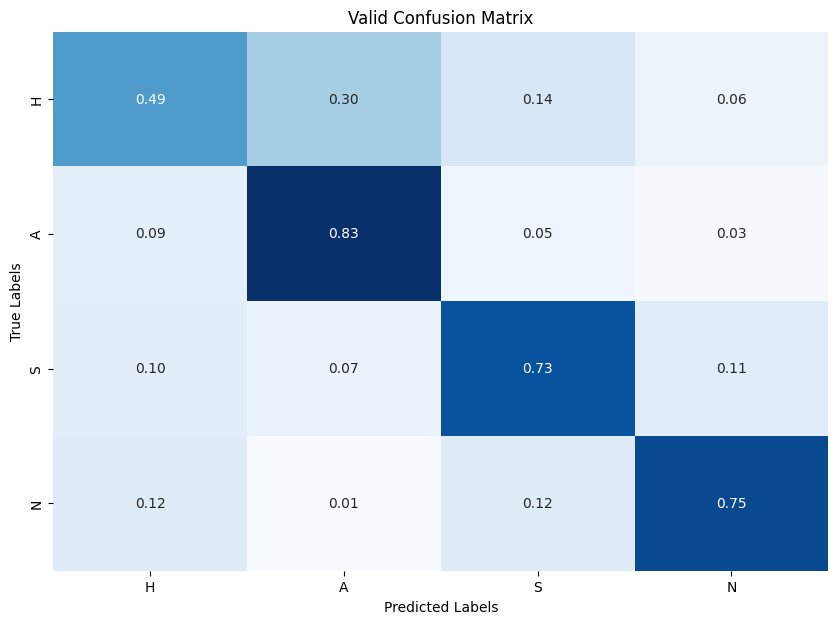

In [103]:
confusion_matrix_evaluation(model, x_valid, y_valid, title='Valid Confusion Matrix')

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


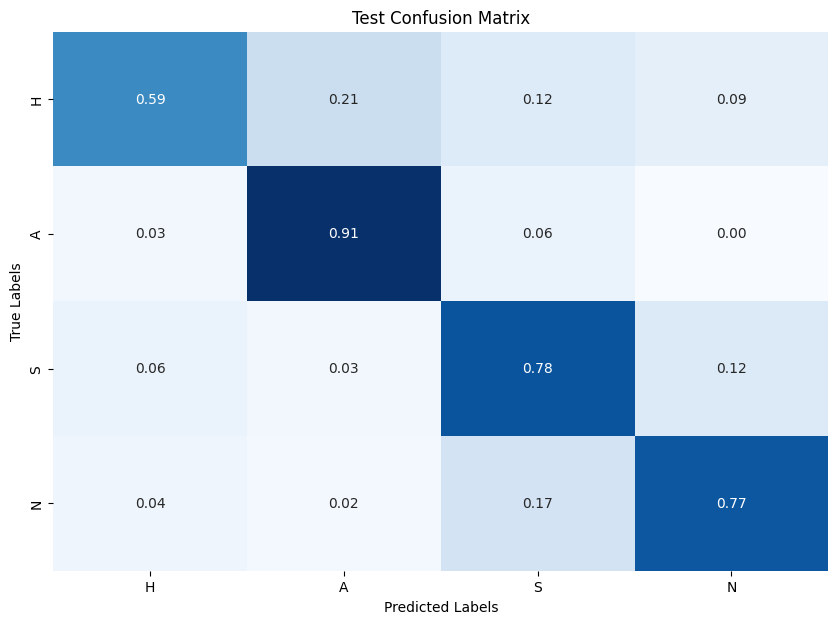

In [104]:
confusion_matrix_evaluation(model, x_test, y_test, title='Test Confusion Matrix')

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


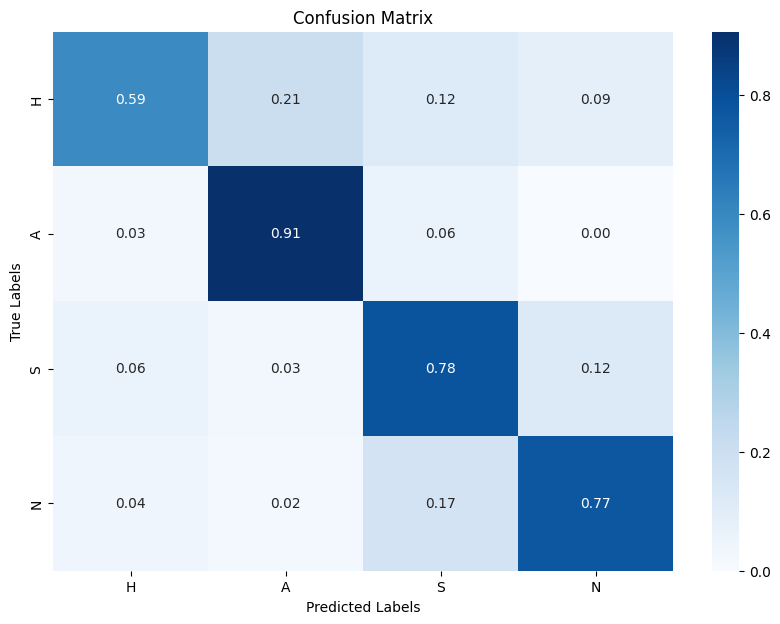

In [88]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluate the model
model.eval()

# Storing all the predictions and actual labels
all_preds = []
all_labels = []

with torch.no_grad():
    for data, label in zip(x_test, y_test):
        outputs = model(torch.tensor(data, dtype=torch.float).to(device).unsqueeze(0))
        predicted = torch.argmax(outputs, -1)
        all_preds.extend(predicted.numpy())
        all_labels.extend(np.argmax(label.reshape(1,-1), -1))

# Calculate the confusion matrix
cm = confusion_matrix(all_labels, all_preds, normalize='true')

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
class_names = ['H', 'A', 'S', 'N']
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
